### Import libraries

In [738]:
import pandas as pd
import os
#import deeplabcut
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import namedtuple
from scipy.spatial import distance
from pathlib import Path

### Set directory and read files

In [790]:
#set directory
data_dir = "/Users/eloisefunnell/Downloads/OPL_Final"
mouse_ids = [f for f in os.listdir(data_dir) if (os.path.isdir(os.path.join(data_dir, f)))]

print(mouse_ids)

['MAR', 'MPV4_MC0', 'M7R', 'M70', 'MFR', 'ME0', 'MPV4_MA10', 'MPV4_MA11', 'MPV3_MA10', 'M4L', 'MPV4_MA1', 'MPV3_MA20', 'M7L', 'MPV3_MA11', 'MPV4_MB1', 'MPV4_MB10', 'MEL', 'MPV4_MB11', 'MFL']


In [791]:
#function to read DLC csv files as df reproducibly 
def read_session_csv(data_dir, mouse_id, session_date):
    session_path = os.path.join(data_dir, mouse_id, session_date)
    session_files = [f for f in os.listdir(session_path) if (f.endswith(".csv"))]
    session_csv = os.path.join(session_path, session_files[0])
    df = pd.read_csv(session_csv, header=[1,2], index_col=0)
    df.name = mouse_id+"_"+session_date
    return df

In [838]:
#import data
mouse = 'MPV4_MB11'
session = '2'
group = 'Control'

#if session 1, leave as 'left' and 'right'
left_obj = 'left' 
right_obj = 'right' 

#if session 2, note which object has been moved otherwise na
familiar = 'right'
novel = 'left'

sess_df = read_session_csv(data_dir, mouse, session)

#run rest of script + output csv will be saved with behaviour summary for animal 
sess_df.head()

bodyparts        nose                           headleft              \
coords              x           y likelihood           x           y   
0          220.295959  109.514076   0.002564  237.878296  106.059944   
1          220.335983  109.586952   0.002602  237.909943  106.079437   
2          220.289978  109.569153   0.002690  237.933807  106.042503   
3          220.309921  109.561539   0.002645  237.905228  106.053169   
4          220.306488  109.562622   0.002696  237.900833  106.049767   

bodyparts              headright                            objectA  \
coords    likelihood           x           y likelihood           x   
0           0.001249  218.639832  110.922623   0.002093  224.191727   
1           0.001211  218.729538  110.937683   0.002159  224.182785   
2           0.001224  218.736389  110.902641   0.002198  224.146988   
3           0.001208  218.745209  110.910042   0.002169  224.156067   
4           0.001229  218.739517  110.926720   0.002207  224.149033   

bodyparts                            objectB                         
coords              y likelihood           x           y likelihood  
0          102.228973        1.0  350.270294  184.699692   0.999983  
1          102.163574        1.0  350.308563  184.713943   0.999983  
2          102.193588        1.0  350.316132  184.736069   0.999984  
3          102.188545        1.0  350.317535  184.720932   0.999983  
4          102.170067        1.0  350.318146  184.719971   0.999984

## Analysis

For both *training* and *test* sessions:

Extract:
- trajectory (trace and heatmap)
- time in ROIs
- locomotion (distance travelled)



In [839]:
#select body parts to track

bps_first=sess_df.columns.get_level_values(0)
bps_to_plot=['nose', 'objectA', 'objectB']


sess_df.head()

bodyparts        nose                           headleft              \
coords              x           y likelihood           x           y   
0          220.295959  109.514076   0.002564  237.878296  106.059944   
1          220.335983  109.586952   0.002602  237.909943  106.079437   
2          220.289978  109.569153   0.002690  237.933807  106.042503   
3          220.309921  109.561539   0.002645  237.905228  106.053169   
4          220.306488  109.562622   0.002696  237.900833  106.049767   

bodyparts              headright                            objectA  \
coords    likelihood           x           y likelihood           x   
0           0.001249  218.639832  110.922623   0.002093  224.191727   
1           0.001211  218.729538  110.937683   0.002159  224.182785   
2           0.001224  218.736389  110.902641   0.002198  224.146988   
3           0.001208  218.745209  110.910042   0.002169  224.156067   
4           0.001229  218.739517  110.926720   0.002207  224.149033   

bodyparts                            objectB                         
coords              y likelihood           x           y likelihood  
0          102.228973        1.0  350.270294  184.699692   0.999983  
1          102.163574        1.0  350.308563  184.713943   0.999983  
2          102.193588        1.0  350.316132  184.736069   0.999984  
3          102.188545        1.0  350.317535  184.720932   0.999983  
4          102.170067        1.0  350.318146  184.719971   0.999984

In [840]:
#define ROIs, selecting coordinates with high likelihood and setting scale 
objR = sess_df['objectB'][sess_df['objectB','likelihood'] > 0.9].mean()
objL = sess_df['objectA'][sess_df['objectA','likelihood'] > 0.9].mean()

objR.name = 'Right'
objL.name = 'Left'

objs = [objL, objR]

#object sizes (px and cm) measured using box and video dimensions - for mpv3 control group 
#objwidth_px = 50 
#objwidth_cm = 3.9
#scale = 3.9/50
#analysis_radius_cm = 3
#analysis_radius_px = analysis_radius_cm/scale
#total_radius_px = analysis_radius_px + objwidth_px
#boxlength_cm = 49.5
#boxlength_px = boxlength_cm/scale
#boxwidth_cm = 30
#boxwidth_px = boxwidth_cm/scale


#object sizes (px and cm) measured using box and video dimensions - for mpv4 control group 
objwidth_px = 21 
objwidth_cm = 3.9
scale = 3.9/21
analysis_radius_cm = 3
analysis_radius_px = analysis_radius_cm/scale
total_radius_px = analysis_radius_px + objwidth_px
boxlength_cm = 49.5
boxlength_px = boxlength_cm/scale
boxwidth_cm = 30
boxwidth_px = boxwidth_cm/scale


#object sizes (px and cm) measured using box and video dimensions - for APP group 
#objwidth_px = 21
#objwidth_cm = 3.9
#scale = 3.9/21
#analysis_radius_cm = 3
#analysis_radius_px = analysis_radius_cm/scale
#total_radius_px = analysis_radius_px + objwidth_px
#boxlength_cm = 49.5
#boxlength_px = boxlength_cm/scale
#boxwidth_cm = 30
#boxwidth_px = boxwidth_cm/scale



#cm / pixels = scale
#cm / scale = pixels
#pixel * scale = cm 


print(total_radius_px)

37.15384615384615


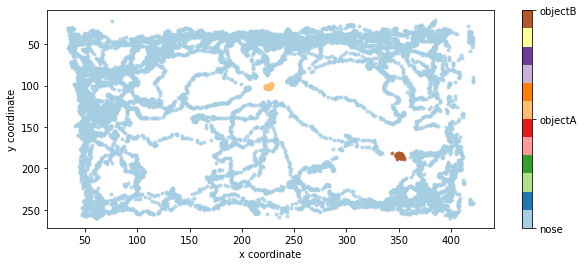

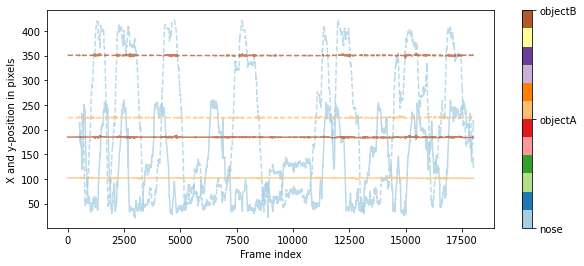

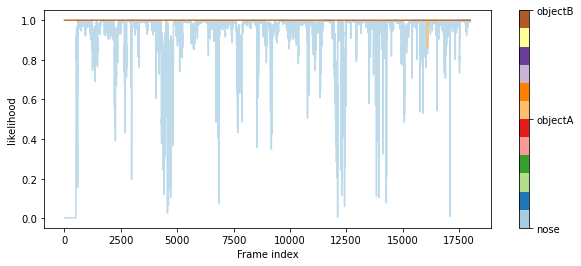

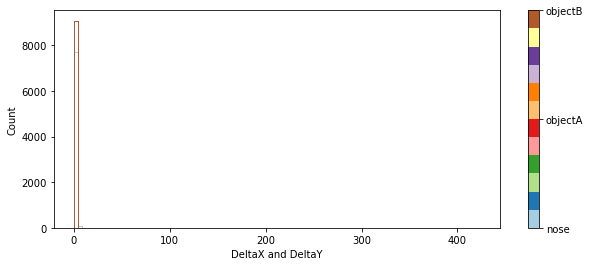

In [841]:
#visualise movement of selected body parts

def get_cmap(n, name='plasma'):
    return plt.cm.get_cmap(name, n)

def Histogram(vector,color,bins):
    dvector=np.diff(vector)
    dvector=dvector[np.isfinite(dvector)]
    plt.hist(dvector,color=color,histtype='step',bins=bins)

def PlottingResults(sess_df,bps_to_plot,alphavalue=.3,pcutoff=.9,colormap='Paired',fs=(4,3)):
    ''' Plots poses vs time; pose x vs pose y; histogram of differences and likelihoods.'''
    plt.figure(figsize=fs)
    colors = get_cmap(len(bps_to_plot),name = colormap)
    scorer=sess_df.columns.get_level_values(0)[0] #you can read out the header to get the scorer name!
    plt.xlabel('x coordinate')
    plt.ylabel('y coordinate')

    for bpindex, bp in enumerate(bps_to_plot):
        Index=sess_df[bp]['likelihood'].values > pcutoff
        plt.plot(sess_df[bp]['x'].values[Index],sess_df[bp]['y'].values[Index],'.',color=colors(bpindex),alpha=alphavalue)

    plt.gca().invert_yaxis()
    plt.savefig(os.path.join(data_dir,"trajectory"+mouse + session))

    
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bps_to_plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bps_to_plot)))
    cbar.set_ticklabels(bps_to_plot)
    plt.figure(figsize=fs)
    Time=np.arange(np.size(sess_df[bps_to_plot[0]]['x'].values))
    #plt.savefig(os.path.join(data_dir,"trajectory"+mouse + session))

    for bpindex, bp in enumerate(bps_to_plot):
        Index=sess_df[bp]['likelihood'].values > pcutoff
        plt.plot(Time[Index],sess_df[bp]['x'].values[Index],'--',color=colors(bpindex),alpha=alphavalue)
        plt.plot(Time[Index],sess_df[bp]['y'].values[Index],'-',color=colors(bpindex),alpha=alphavalue)       
        
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bps_to_plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bps_to_plot)))
    cbar.set_ticklabels(bps_to_plot)
    plt.xlabel('Frame index')
    plt.ylabel('X and y-position in pixels')
    #plt.savefig(os.path.join(tmpfolder,"plot"+suffix))

    plt.figure(figsize=fs)
    for bpindex, bp in enumerate(bps_to_plot):
        Index=sess_df[bp]['likelihood'].values > pcutoff
        plt.plot(Time,sess_df[bp]['likelihood'].values,'-',color=colors(bpindex),alpha=alphavalue)

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bps_to_plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bps_to_plot)))
    cbar.set_ticklabels(bps_to_plot)
    plt.xlabel('Frame index')
    plt.ylabel('likelihood')

    #plt.savefig(os.path.join(tmpfolder,"plot-likelihood"+suffix))

    plt.figure(figsize=fs)
    bins=np.linspace(0,np.amax(sess_df.max()),100)

    for bpindex, bp in enumerate(bps_to_plot):
        Index=sess_df[bp]['likelihood'].values < pcutoff
        X=sess_df[bp]['x'].values
        X[Index]=np.nan
        Histogram(X,colors(bpindex),bins)
        Y=sess_df[bp]['x'].values
        Y[Index]=np.nan
        Histogram(Y,colors(bpindex),bins)

    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap(colormap), norm=plt.Normalize(vmin=0, vmax=len(bps_to_plot)-1))
    sm._A = []
    cbar = plt.colorbar(sm,ticks=range(len(bps_to_plot)))
    cbar.set_ticklabels(bps_to_plot)
    plt.ylabel('Count')
    plt.xlabel('DeltaX and DeltaY')
    
    #plt.savefig(os.path.join(tmpfolder,"hist"+suffix))


%matplotlib inline
PlottingResults(sess_df,bps_to_plot,alphavalue=.75,pcutoff=.9,fs=(10,4))


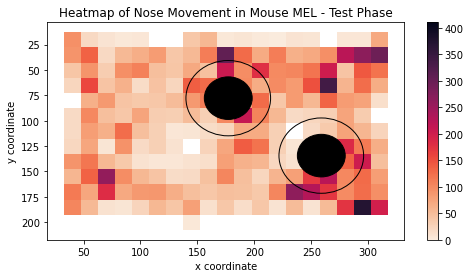

In [824]:
# plotting a heatmap using x and y correlation 
plt.rcParams.update({
    "figure.facecolor":  (1.0, 1.0, 1.0, 1),  # red   with alpha = 30%
    "axes.facecolor":    (1.0, 1.0, 1.0, 1),  # green with alpha = 50%
    "savefig.facecolor": (1.0, 1.0, 1.0, 1),  # blue  with alpha = 20%
})
plt.rcParams['savefig.dpi'] = 300

bp = 'nose'
ind = sess_df[bp] 
heatmap_df = ind[~(ind['likelihood'] < 0.9)].drop(columns=['likelihood']) 
f = plt.figure(figsize=(8,4))
ax = f.subplots()
sns.histplot(heatmap_df,x='x', y='y', cbar=True, ax=ax, binwidth=(15, 15), cmap='rocket_r')
circle1 = plt.Circle((objs[0]['x'],objs[0]['y']), total_radius_px, facecolor='none', edgecolor='black')
circle2 = plt.Circle((objs[1]['x'],objs[1]['y']), total_radius_px, edgecolor='black', facecolor='none')
circle11 = plt.Circle((objs[0]['x'],objs[0]['y']), objwidth_px,color='black')
circle22 = plt.Circle((objs[1]['x'],objs[1]['y']), objwidth_px, color='black')
ax.add_patch(circle1)
ax.add_patch(circle2)
ax.add_patch(circle11)
ax.add_patch(circle22)
ax.invert_yaxis()
plt.xlabel('x coordinate')
ax.set_title('Heatmap of Nose Movement in Mouse ' + mouse + ' - Test Phase')
plt.ylabel('y coordinate')

plt.savefig('MEL_2_heatmap_plot.png', transparent=False)

In [754]:
#functions to identify chosen body parts within analysis radius
def check_bp_in_circle(radius,center,bp_point):
    if ((bp_point[0] - center[0])**2+(bp_point[1] - center[1])**2) <= (radius**2):
        return True
    else:
        return False

def frames_in_area(bp_df,area_settings):
    if area_settings['type'] == 'circle':
        in_area = []
        for frame in bp_df.index:
            in_area.append(check_bp_in_circle(area_settings['radius'],area_settings['center'], bp_df.loc[frame]))
        bp_df['in'+area_settings['center'].name] = in_area
        return bp_df

In [681]:
#select body part for ROI analysis + create df of coordinates with high likelihood
chosen_bp = 'nose'
bp_df = sess_df[chosen_bp][sess_df[chosen_bp,'likelihood'] > 0.9][['x','y']]

#check frame skips - if high adjust threshold or refine network 
print(np.diff(bp_df.index).max())

bp_df.head()

608


coords,x,y
580,480.762543,278.700958
581,480.246826,277.195984
582,482.719543,278.466278
586,482.271423,269.011353
592,469.645874,246.508545


In [682]:
#create df of frames where bodypart present in either ROI 
fia_left = frames_in_area(bp_df, {'type':'circle', 'radius': total_radius_px, 'center':objs[0]})
fia_right = frames_in_area(bp_df, {'type':'circle', 'radius': total_radius_px, 'center':objs[1]})

fia_both = frames_in_area(bp_df, {'type':'circle', 'radius': total_radius_px, 'center':objs[1]})

#fia_left.to_csv("fia_left_Frames.csv")
#fia_right.to_csv("fia_right_Frames_Right.csv")


fia_both["inLeft"] = fia_both["inLeft"].astype(int)
fia_both["inRight"] = fia_both["inRight"].astype(int)

#fia_both.to_csv("m4l_both.csv")

fia_left

coords,x,y,inLeft,inRight
580,480.762543,278.700958,0,0
581,480.246826,277.195984,0,0
582,482.719543,278.466278,0,0
586,482.271423,269.011353,1,0
592,469.645874,246.508545,1,0
...,...,...,...,...
17995,348.685852,396.683777,0,0
17996,350.071289,395.910614,0,0
17997,349.392517,395.691986,0,0
17998,348.650146,396.065338,0,0


In [683]:
#identify no. of 'frames in area' where body part was within ROI for at least 90 frames (1.5 seconds)

#identify frames where body part present in ROI 
fia_left['tag_l'] = fia_left['inLeft'] == 1
fia_right['tag_r'] = fia_right['inRight'] == 1

#first row is a True preceded by a False
first_l = fia_left.index[fia_left['tag_l'] & ~ fia_left['tag_l'].shift(+1).fillna(False)]
first_r = fia_right.index[fia_right['tag_r'] & ~ fia_right['tag_r'].shift(+1).fillna(False)]

#last row is a True followed by a False
last_l = fia_left.index[fia_left['tag_l'] & ~ fia_left['tag_l'].shift(-1).fillna(False)]
last_r = fia_right.index[fia_right['tag_r'] & ~ fia_right['tag_r'].shift(-1).fillna(False)]

#filter rows which are apart by 90 frames (1.5s) or more
pr_l = [(i, j) for i, j in zip(first_l, last_l) if j > i + 89]
pr_r = [(i, j) for i, j in zip(first_r, last_r) if j > i + 89]

#create dictionaries to hold all the fia_l and fia_r names
dict_of_fia_l = {}
dict_of_fia_r = {}

#loop around pr_l rows and populate each fia_l dataset into a dictionary
for n in range(len(pr_l)):
    i,j = pr_l[n]
    key_name = 'fia_'+ str(n) + '_l'
    #store fia_l data into temporary dataframe 
    df_temp_l = fia_left.loc[i:j]
    df_temp_l.insert(0, "Group", key_name, True)
    dict_of_fia_l[key_name] = df_temp_l

#loop around the pr_r rows and populate each fia_r dataset into a dictionary
for n in range(len(pr_r)):
    i,j = pr_r[n]
    key_name = 'fia_'+ str(n) + '_r'
    #store fia_r data into temporary dataframe
    df_temp_r = fia_right.loc[i:j]
    df_temp_r.insert(0, "Group", key_name, True)
    dict_of_fia_r[key_name] = df_temp_r
    
#create a dataframe and populate with all the fia_l datasets
fia_final_l = pd.concat(dict_of_fia_l, ignore_index=False)

#create a dataframe and populate with all the fia_r datasets
fia_final_r = pd.concat(dict_of_fia_r, ignore_index=False)

#output the left and right dataframes to csv file
#fia_final_l.to_csv("fia_final_l.csv", index=True)
#fia_final_r.to_csv("fia_final_r.csv", index=True)

#total number of rows to find no. of frames where animal investigated for 1.5+ seconds
total_ROItime_l_f = len(fia_final_l)
print(total_ROItime_l_f)

total_ROItime_r_f = len(fia_final_r)
print(total_ROItime_r_f)

#in seconds
total_ROItime_l_s = round(total_ROItime_l_f/60, 2)
total_ROItime_r_s = round(total_ROItime_r_f/60, 2)

#calculate total number of entries into each ROI
number_entries_l = fia_final_l["Group"].nunique()
number_entries_r = fia_final_r["Group"].nunique()

print(total_ROItime_l_s)
print(number_entries_r)

pr_r

143
253
2.38
2


[(3479, 3587), (14956, 15164)]

In [684]:
#total no. of frames nose spent in ROIs 
frames_OL = fia_both['in'+objs[0].name].sum()
frames_OR = fia_both['in'+objs[1].name].sum()
#totalframes = round((len(fia_both['in'+objs[0].name]))/60, 2)

#time inside ROI in seconds
time_OL = round(frames_OL/60, 2)
time_OR = round(frames_OR/60, 2)

#proportion of total time inside ROIs
propframes_OL = round(fia_both['in'+objs[0].name].sum()/len(fia_both['in'+objs[0].name]), 2)
propframes_OR = round(fia_both['in'+objs[1].name].sum()/len(fia_both['in'+objs[1].name]), 2)

In [788]:
#summarise locomotion 

#create array with x y nose coordinates
nose_xy_1 = sess_df['nose'].drop(columns='likelihood')
pairs = nose_xy_1.to_numpy()


#function to compare x y coordinates with previous frame and calculate difference
def locomotion(pairs):
    # loop over each pair of points and extract distances
    dist = []
    for n, pos in enumerate(pairs):
        # Get a pair of points
        if n == 0:  # get the position at time 0, velocity is 0
            p0 = pos
            dist.append(0)
        else:
            p1 = pos  # get position at current frame

            # Calc distance
            dist.append(np.abs(distance.euclidean(p0, p1)))

            # Prepare for next iteration, current position becomes the old one and repeat
            p0 = p1

    return np.array(dist)

#sum differences to find total distance moved in pixels and cm 
px_moved_1 = locomotion(pairs)

total_moved_px = px_moved_1.sum().round(2)
total_moved_cm = round((total_moved_px * scale), 2)

#calculate the discrimination index
di = round(((total_ROItime_r_s - total_ROItime_l_s) / (total_ROItime_r_s + total_ROItime_l_s))*100, 2)

px_moved_1

array([0.        , 0.08314333, 0.0493285 , ..., 1.57112702, 1.86861007,
       3.59049216])

In [686]:
#create a final df with summary of animal behaviour 

#average time spent in L ROI (s)? - not for one animal ?
#average time spent in R ROI (s)? - not for one animal ? 


final_df = pd.DataFrame([[mouse, session, group, familiar, novel, total_moved_cm, total_moved_px, total_ROItime_l_f, total_ROItime_r_f, total_ROItime_l_s, total_ROItime_r_s, frames_OL, propframes_OL, time_OL, frames_OR, propframes_OR, time_OR, number_entries_l, number_entries_r, di]],
                        columns=['mouse id', 'session', 'group', 'familiar', 'novel', 't_move_cm', 't_move_px', ('t_fr_' + left_obj), ('t_fr_' + right_obj), ('t_s_' + left_obj), ('t_s_' + right_obj), ('sum_fr_' + left_obj), ('prop_fr_' + left_obj), ('sum_s_' + left_obj), ('sum_fr_' + right_obj), ('prop_fr_' + left_obj), ('sum_s_' + right_obj), ('entries_' + left_obj), ('entries_' + right_obj), 'di'])


#save to csv
final_name = mouse + session
#final_df.to_csv(final_name+"results.csv", index=False) 
#specify save to folder?

In [687]:
final_df.head()

,mouse id,session,group,familiar,novel,t_move_cm,t_move_px,t_fr_left,t_fr_right,t_s_left,t_s_right,sum_fr_left,prop_fr_left,sum_s_left,sum_fr_right,prop_fr_left,sum_s_right,entries_left,entries_right,di
0,MPV3_MA20,2,Control,right,left,24039.12,308193.89,143,253,2.38,4.22,675,0.12,11.25,525,0.09,8.75,4,2,27.88


-27.878787878787882